# Text Analysis from The Last of Us 2 Metacritic Users Reviews

This notebook seeks to extract and analyze text data from Metacritic Users Reviews, to try and understand the review bombing the game suffered with its release.

It is worth remembering that this analysis contains **SERIOUS SPOILERS** from the Last of Us 2, so proceed at your own risk.

First, we will use `beatiful soup` to extract the reviews from the website. Then, we will use a number of text analysis libs to generate insights from the gathered data.

-------------------

## 1. Importing Libs

Below, we import the libs we will use over the analysis:

In [248]:
import pandas as pd ## As usual, to deal with our dataframes
import requests ## To access the website
from bs4 import BeautifulSoup ## To extract the html features from the page
import time as time ## To respectfuly gather data from the site and don't overwhelm them.
import random as rand 
from IPython.display import clear_output, Image
from collections import Counter
import string

import nltk # imports the natural language toolkit
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk.util import ngrams ## Very useful to understand n-grams on text.

import re


import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Extracting Data

First, we will create a dictionary that will store the gathered data into our desired bins. For this analysis, we will extract the date of the review, the rating of the review and the text.

In [192]:
review_dict = {'date':[], 'rating':[], 'review':[]}


In [193]:
user_agents_list = ['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36',
                    'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36',
                    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36',
                    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
                    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
                    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36']

Below, we gather the data from the website.

I gathered data from the first 367 pages, that were the total number of pages in the moment of analysis.

I've also set a sleep time of 1 second, so we don't affect too much the traffic in the website.

In [119]:
for page in range(0,367): #Remember to update the number of pages 
    url = 'https://www.metacritic.com/game/playstation-4/the-last-of-us-part-ii/user-reviews?sort-by=score&num_items=100&page='+str(page)
    user_agent = {'User-agent': user_agents_list[rand.randint(0,len(user_agents_list)-1)]}
    response  = requests.get(url, headers = user_agent)
    time.sleep(1) 
    soup = BeautifulSoup(response.text, 'html.parser')
    
    ## Here, we loop through all html div classes with the 'review content' tag. Those are the review blocks.
    for review in soup.find_all('div', class_='review_content'):
        
        ## Here, we check if the name or review are empty, if so, we skip this review.
        if review.find('div', class_='name') == None or review.find('div', class_='review_body').find('span') == None:
                break
        review_dict['date'].append(review.find('div', class_='date').text)
        review_dict['rating'].append(review.find('div', class_='review_grade').find_all('div')[0].text)
        ## Now, we check if the review is hidden due to its size. If so, we take the review from within this object.
        if review.find('span', class_='blurb blurb_expanded'):
            review_dict['review'].append(review.find('span', class_='blurb blurb_expanded').text)

        else:
            review_dict['review'].append(review.find('div', class_='review_body').find('span').text)
    
    ## This just prints the page we're in
    clear_output(wait = True)    
    print(page)
    
clear_output(wait = True)    

366


Now, we convert the dictionary filled with our data to a DataFrame.

In [123]:
reviews = pd.DataFrame(review_dict)

Below, we saved our dataframe to a csv, so we don't need to crawl the website everytime.

In [2]:
#reviews.to_csv('datasets/reviews.csv')
reviews = pd.read_csv('datasets/reviews.csv')

## 3. Review Analysis

First, let us do some non-textual analysis. Let's understand the distribution of the ratings over the days.

Also, let's keep in mind some key information:

1. The game was released on June 19th.
2. The average gameplay time is +/- 25 hours


### 3.1 Reviews per day

Let's first understand the distribution of reviews per day.

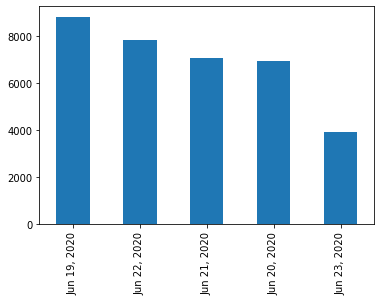

In [3]:
reviews['date'].value_counts().plot.bar();

We see that the majority of reviews were made on the release date. This is a good sign of review bombing, given that people would not have the time to play the game and offer a proper review. It may also suggest that the game is really bad and that you could say that after a few hours into it.

But let's dig deeper. Let's break that graph into good and bad reviews.

In [4]:
reviews['rating'] = reviews['rating'].astype(int)

reviews['good'] = False
reviews.loc[reviews['rating'] > 6,'good'] = True

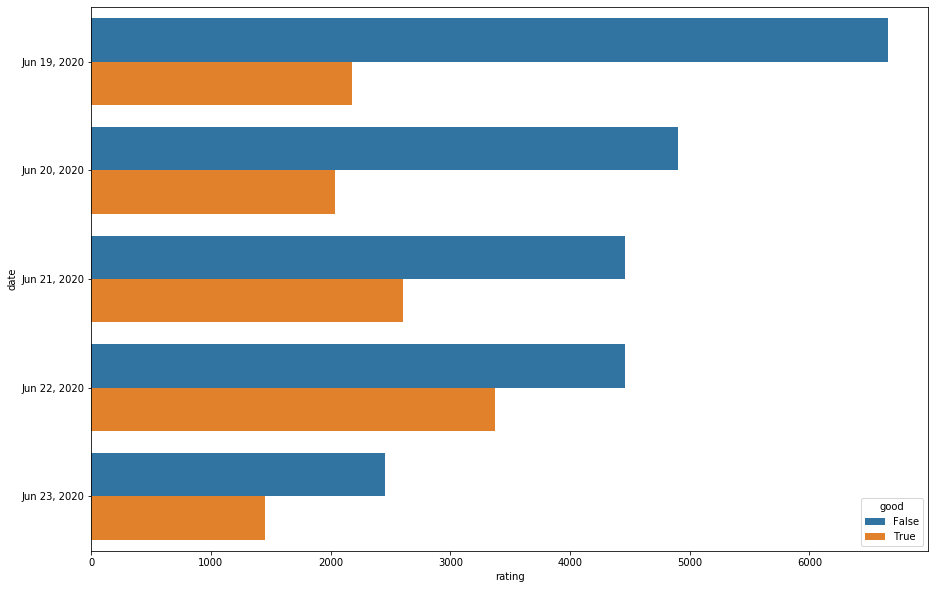

In [5]:
fig, ax = plt.subplots(figsize = (15,10))

sns.barplot(y = 'date',
            x = 'rating', 
            hue = 'good',
            data = reviews.groupby(['date','good'])['rating'].count().reset_index());

As we can see, good reviews only reached a peak days after the release of the game, which may suggest that people actually played the whole game before reviewing.

Now, let's take a look at the rating behaviour.

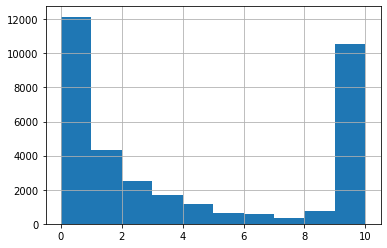

In [6]:
reviews['rating'].hist();

We can see that there is a huge polarization between 0's and 10's.

### 3.2 Text Pre-Processing

Here we will treat the text to make it easier to analyze.

First of all, let's convert all text to lower caps:

In [7]:
reviews['review'] = reviews['review'].apply(lambda x: x.lower())

Now, let's get rid of special characters:

In [8]:
review_backup = reviews['review'].copy()
reviews.review = reviews['review'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

Now, we will create a function that takes a column with the reviews and converts it to word tokens, so we can better analyze the reviews. 

Also, it will remove english stopwords and stem them. Stemming is a process that trims words, taking out common prefixes and suffixes, so you can group words that were written differently but have the same meaning.

A good example of the stemming process is shown below:

<img src="images/stem.PNG" alt="ngrams" width="400"/>

Now, we will create two functions, one that will use a column as input, and one that will use a string.


In [120]:
def get_word_tokens_col(series):
    '''
    This function gets all the text from one column and converts it to word tokens.
    
    Parameters:
    series: Column to be broken down into word tokens
    
    Returns: Word tokens
    
    '''
    eng_stopwords = stopwords.words('english')
    ### Getting a single string
    text = ' '.join(series)
    ## Splitting them into tokens
    word_tokens = nltk.word_tokenize(text)
    ## Removing the stopwords and Stemming
    ps = PorterStemmer() 
    word_tokens_clean = [ps.stem(each) for each in word_tokens if each.lower() not in eng_stopwords and len(each.lower()) > 2]
    return word_tokens_clean

In [122]:
def get_word_tokens_text(text):
    '''
    This function gets all the text from one column and converts it to word tokens.
    
    Parameters:
    series: Column to be broken down into word tokens
    
    Returns: Word tokens
    
    '''
    eng_stopwords = stopwords.words('english')
    ## Splitting them into tokens
    word_tokens = nltk.word_tokenize(text)
    ## Removing the stopwords and Stemming
    ps = PorterStemmer() 
    word_tokens_clean = [ps.stem(each) for each in word_tokens if each.lower() not in eng_stopwords and len(each.lower()) > 2]
    return word_tokens_clean

Now, we create a function that uses the function above to get the word tokens and get the top k n-grams from any text column. That is, it presents us the most common combination of any number of words in our reviews.

The image below gives a better view of ngrams:

<img src="images/ngrams.PNG" alt="ngrams" width="400"/>

One very good use of this feature is to understand the differences between positive and negative reviews' n-grams.

In [123]:
def top_k_ngrams(series,n,k,mode):
    '''
    This function gets the top k n-grams from a column.
    
    Parameters:
    series: column to be analyzed
    n: integer that represent the number of words to connect
    k: integer with that limits the ranking
    mode: True if the input is a column, False if it is a chunk of text
    
    
    Returns: text with top k n-grams
    '''
    ## Getting them as n-grams
    if mode == True:
        word_tokens = get_word_tokens_col(series)
    else:
        word_tokens = get_word_tokens_text(series)
    n_gram_list = list(ngrams(word_tokens, n))
    ### Getting each n-gram as a separate string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    return list(most_common_k)

Now, we break our datasets into bad and good reviews, so we can analyze them apart.

In [48]:
reviews_good = reviews[reviews['rating'] > 6]
reviews_bad = reviews[reviews['rating'] < 5]

### 3.3 n-Grams Analysis

Alright! Now let's see the top 15 n-grams for both good and bad reviews.

**Bad Reviews** first:

In [124]:
top_k_ngrams(reviews_bad['review'],1,15,True)

[('game', 40146),
 ('stori', 15891),
 ('charact', 11083),
 ('play', 8400),
 ('first', 7844),
 ('joel', 7760),
 ('like', 7683),
 ('elli', 6035),
 ('kill', 5627),
 ('gameplay', 5561),
 ('make', 5540),
 ('one', 5357),
 ('bad', 5316),
 ('good', 5288),
 ('graphic', 4927)]

Well, obviously we have some pretty expected words, such as `game`, `bad`, `play`, `good`. We could have solved that problem by trimming away the 5th percentile of most common words. But in this case, I believe that analyzing them could give us good insight. 

As we can see, `story` is the second most common word, that may lead to something, most of all because it is followed by `Joel`, `Ellie` and `character`. That is, most of the common words are related to the gameplot.

Now, let's see if the bigrams gives us more insight:

In [125]:
top_k_ngrams(reviews_bad['review'],2,15,True)

[('first game', 4181),
 ('naughti dog', 3362),
 ('play game', 1244),
 ('game play', 1203),
 ('kill joel', 1046),
 ('feel like', 983),
 ('game stori', 974),
 ('joel elli', 933),
 ('video game', 854),
 ('first one', 821),
 ('buy game', 773),
 ('last part', 738),
 ('nesnasim gay', 708),
 ('gay nesnasim', 706),
 ('main charact', 675)]

Well, it's really close to the first, lots of references to the first game, lots of reference to the story. And one bigram that really caught my attention is also a **HUGE** spoiler and it may lead us to something, that is the death of Joel.

Now onwards to the **good reviews**:

In [180]:
top_k_ngrams(reviews_good['review'],1,15,True)

[('game', 21488),
 ('stori', 6927),
 ('play', 5435),
 ('que', 4678),
 ('like', 3708),
 ('peopl', 3450),
 ('elli', 3301),
 ('first', 3202),
 ('charact', 3131),
 ('gameplay', 3128),
 ('one', 3037),
 ('joel', 2959),
 ('part', 2475),
 ('abbi', 2455),
 ('good', 2394)]

Also lots of things related to the story and its characters. Let's see the bigrams:

In [181]:
top_k_ngrams(reviews_good['review'],2,15,True)

[('naughti dog', 1830),
 ('first game', 1353),
 ('play game', 1147),
 ('best game', 1061),
 ('game play', 706),
 ('last part', 679),
 ('game ever', 665),
 ('one best', 540),
 ('great game', 538),
 ('hist ria', 491),
 ('first one', 488),
 ('review bomb', 397),
 ('good game', 396),
 ('video game', 390),
 ('ever play', 380)]

It has less terms related to the story, it is mostly terms related to how good the game is. Also, we can see that is less concentrated than the bad reviews.

### 3.4 Story Analysis 

Now that we saw that most of the complaints are related to the story, one thing that we can do is to look for words connected to the word `story` or `character`, both on the bad reviews and on the good reviews. 

We will make this analysis using the functions we've created previously and another helpful function we will create now.

The function below is used to get the 50 characthers before and after a specified word. We will use it to understand what are they saying abouy specific words.

In [182]:
def loc_word(serie,word):
    '''
    This function seeks and plots all the reviews containing a specific word and the 20 characters before and after it.
    
    Parameters:
    serie: The columns we will look into 
    word: The word it will seek, must be a string
    
    Return:
    String with all the sentences it was found.
    '''
    text = ''
    reviews_containing_word = [each for each in serie if word in each]
    for review in reviews_containing_word:
        word_index = review.find(word)
        sentence = review[word_index-50:word_index+50].replace("\n", "")
        text = text+' '+ sentence
    return text

Now, let's create a wordcloud to plot the top k n-grams from the function above, so we can understand what are the most common expressions related to a given word.


In [246]:
def word_cloud(serie, word, n,k):
    
    ## Counts how many reviews contain the specified word
    n_revs= len(serie[serie.str.contains(word)])
    
    ## Gets the word tokens
    text = loc_word(serie,word)
    
    ## Gets the top n-grams
    top_ngrams = top_k_ngrams(text,n,k,False)
    
    # Creating a word cloud object
    wordcloud = WordCloud(max_font_size=100, max_words=400, background_color="white",\
                          scale = 10,width=800, height=400, collocations = True).generate_from_frequencies(dict(top_ngrams))

    # Plotting the generated word cloud
    plt.figure()
    plt.title('Data from {0} reviews that contains the word "{1}"'.format(n_revs,word))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Now, let's check the top 100 trigrams related to story on bad and good reviews.

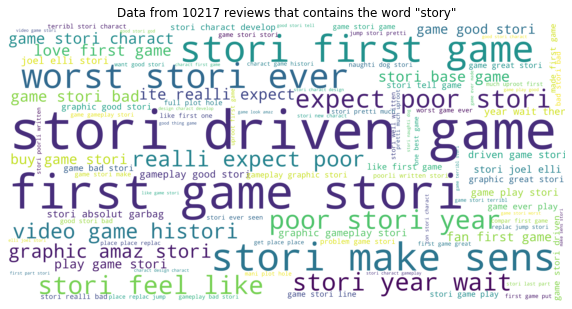

In [247]:
word_cloud(reviews_bad['review'],'story',3,100)

Well, it does not give us much to carry on, just people saying that it was the worst story ever. Now, let's check what is related to the word `character`.

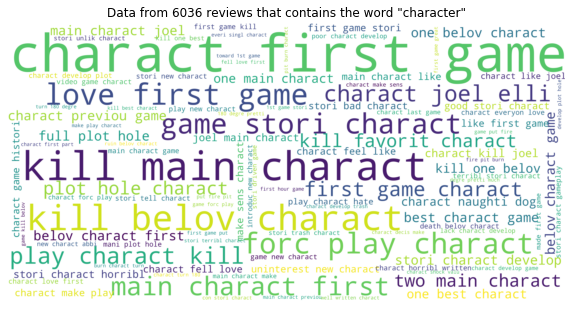

In [227]:
word_cloud(reviews_bad['review'],'character',3,100)

Now, we have something! People are clearly upset about the death of Joel! I must say that I was really surprised by it, I thought that was something to be expected from the trailers, but I think the way it happened and the aftermath may not have pleased everyone.

Also, that matches the data from the dates of the reviews, since this happens in the beggining of the game.

But let's carry on and check the same analysis, but for the **Good Reviews**.

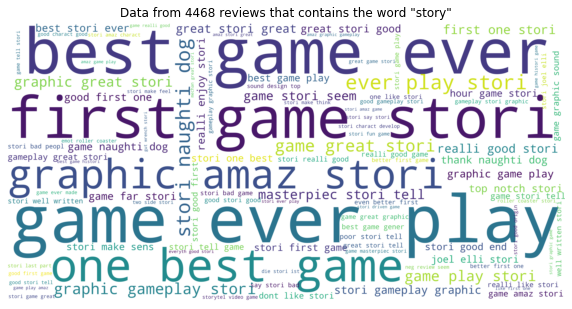

In [228]:
word_cloud(reviews_good['review'],'story',3,100)

Well, it seems that people that liked the game consider it the best game they ever played, and it seems that they put this really close to the word `story`, which may suggest that the story of the game may have something to do with the high quality of the game.

Now let's do it with `character`.

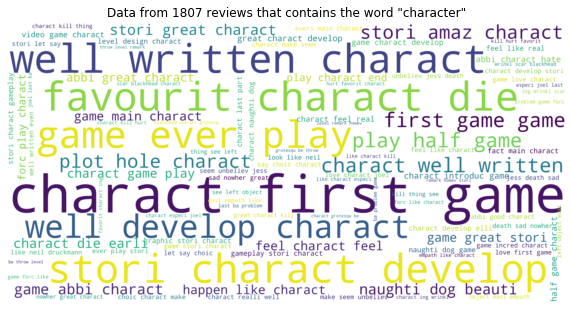

In [229]:
word_cloud(reviews_good['review'],'character',3,100)

It does mention the death of our beloved Joel, but people really seem to like the character development. 

### 3.5 Other expressions TBC